In [41]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from safety_train_new import Extractor, Adaptor, Classifier, FullModel

from glob import glob
from PIL import Image
import torchvision.transforms as transforms
from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


## only image

In [19]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/multi_extractor_small_dataset_20241228/lr_1e-05_visual_feature_extractor_ViT_LLM_loaded_False/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()


In [20]:
def vision_model_test(model, test_loader, model_type='feature_extractor', LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            data, target = data.cuda(), target.cuda().long()
            if model_type == 'feature_extractor':
                output = model(data)['features']
            else:
                output = model(data)
            # output = model(data)['features']
            all_outputs.append(output)
            all_labels.append(target)
    
    
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_outputs, all_labels

def vision_model_single_image(model, image, model_type='feature_extractor', LLM_model=None):
    model.eval()  # 切换到评估模式
    with torch.no_grad():  # 关闭梯度计算，节省内存
        if LLM_model is not None:
            image = LLM_model([image])
        image = image.cuda().unsqueeze(0)  # 添加batch维度
        if model_type == 'feature_extractor':
            output = model(image)['features']
        else:
            output = model(image)
    return output


In [21]:
# error_panoid = []
# for i, row in data.iterrows():
#     panoid = row["Image_ID"]
#     for angle in [0, 90 ,180, 270]:
#         image_path = f"/data2/cehou/LLM_safety/GSV/HK_imgs/{panoid[0]}/{panoid[1]}/{panoid}_{angle}.jpg"
#         img = Image.open(image_path)
#         img = np.array(img)
#         if img.shape != (300, 400, 3):
#             print(image_path)
#             error_panoid.append(panoid)


In [22]:
# data = pd.read_csv(parameters['placepulse_datapath'])
data = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/finished/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl')
data['label'] = 1
data.rename(columns={"panoid": "Image_ID"}, inplace=True)
error_panoid = {'_ZyueibIbaC6UyhG4WcRAA', 'kXQjqDhu9HnvAdIkKl-37Q'}
data = data[~data['Image_ID'].isin(set(error_panoid))]
data_ls = data[data['label'] != 0]
data_ls.loc[data_ls[data_ls['label'] == -1].index, 'label'] = 0
transform = get_transforms((224,224))
train_num = int(len(data_ls) * 0.6)
valid_num = int(len(data_ls) * 0.2)


LLM_pre_extractor = None
one_dataset = SafetyPerceptionDataset(data[:200], transform=transform, paras=parameters, SVI_type="GSV")
one_loader = torch.utils.data.DataLoader(one_dataset, batch_size=parameters['batch_size'])

total_dataset = SafetyPerceptionDataset(data, transform=transform, paras=parameters, SVI_type="GSV") 
total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=parameters['batch_size'])

extractor = Extractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
adaptor = Adaptor(input_dim=parameters['input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
classifier = Classifier(input_dim=parameters['adaptor_output_dim'], num_classes=parameters['num_classes']) # [128, 2]
vision_model = FullModel(extractor, adaptor, classifier).cuda()

# Load the saved model parameters
vision_model.load_state_dict(torch.load(model_path), strict=False)

FileNotFoundError: [Errno 2] No such file or directory: '/data2/cehou/LLM_safety/img_text_data/finished/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl'

In [ ]:
feature_extractor = create_feature_extractor(vision_model, return_nodes={'extractor.model.encoder.ln': 'features'})
all_outputs, all_labels = vision_model_test(feature_extractor, one_loader, model_type='feature_extractor')
# valid_outputs, valid_labels = model_test(model, valid_loader)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


In [7]:
input_image = next(iter(one_loader))[0][1] # 输入图像张量


In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class custom_GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 注册钩子函数来提取特征图和梯度
        self.hook_layers()

    def reshape_transform(tensor, height=14, width=14):
        result = tensor[:, 1 :  , :].reshape(tensor.size(0),
            height, width, tensor.size(2))

        # Bring the channels to the first dimension,
        # like in CNNs.
        result = result.transpose(2, 3).transpose(1, 2)
        return result

    def hook_layers(self):
        # 注册前向钩子和反向钩子
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        
        # 钩子层
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        # 前向传播
        self.model.eval()
        
        input_image = input_image.unsqueeze(0).cuda()
        output = self.model(input_image)
        
        # 反向传播
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward(retain_graph=True)

        # 获取梯度和激活图
        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        print(gradients.shape, activations.shape)

        # 计算每个通道的权重
        if gradients.shape[0] == 1:
            weights = gradients[0, :]
            cam = np.zeros(activations.shape[1], dtype=np.float32)
        else:
            weights = np.mean(gradients, axis=(2, 3))[0, :]  # Global average pooling
            cam = np.zeros(activations.shape[2:], dtype=np.float32)
        
        # 加权特征图
        for i, weight in enumerate(weights):
            if activations.shape[0] == 1:
                cam[i] = weight * activations[0, i]
            else:
                cam += weight * activations[0, i, :, :]
        
        # 归一化
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

    def overlay_cam_on_image(self, input_image, cam):
        # 生成原图和热图叠加的结果
        input_image = input_image.squeeze().cpu().numpy().transpose((1, 2, 0))
        input_image -= np.min(input_image)
        input_image /= np.max(input_image)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlayed_image = cv2.addWeighted(input_image, 0.6, heatmap, 0.4, 0)

        return overlayed_image

target_layer = model.adaptor.layer_norm
gradcam = custom_GradCAM(model, target_layer)
target_class = 0  # 目标类别
cam_classifier = gradcam.generate_cam(input_image, target_class)
cam_classifier_1dim = cam_classifier[:,0]

(1, 256) (1, 256)


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1372: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [9]:
import argparse
import cv2
import numpy as np
import torch
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from tqdm import tqdm

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

methods = \
    {"gradcam": GradCAM,
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
        "eigengradcam": EigenGradCAM,
        "layercam": LayerCAM,
        "fullgrad": FullGrad}



vit_model = torch.hub.load('facebookresearch/deit:main',
                        'deit_tiny_patch16_224', pretrained=True).cuda().eval()


target_layers = [vit_model.blocks[-1].norm1]
input_tensor = input_image.unsqueeze(0).cuda()
# targets = None

for i in tqdm(range(1000)):
    targets = [ClassifierOutputTarget(i)]
    # targets = None

    cam = GradCAM(model=vit_model,
                target_layers=target_layers,
                reshape_transform=reshape_transform)

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    # cam.batch_size = 32

    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)

    if i == 0:
        total_cam = grayscale_cam
    else:
        total_cam = np.concatenate([grayscale_cam, total_cam], axis=0)
    # Here grayscale_cam has only one image in the batch
    # grayscale_cam = grayscale_cam[0, :]

# cam_image = show_cam_on_image(rgb_img, grayscale_cam)
# cv2.imwrite(f'{args.method}_cam.jpg', cam_image)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
/usr/local/lib/python3.8/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.8/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py

<Axes: >

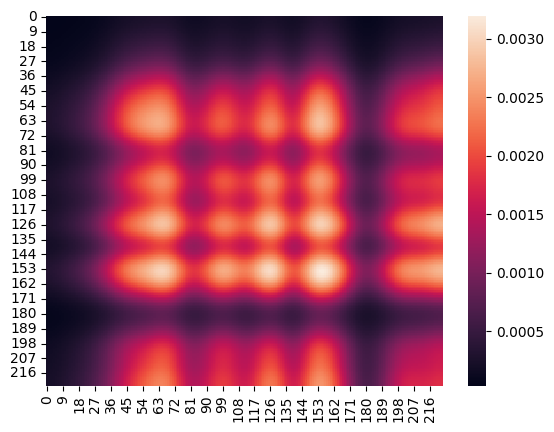

In [10]:
cam_classifier_2d = cam_classifier * cam_classifier.T
updated_cam = total_cam.mean(axis=0) * cam_classifier_2d
smoothed_cam = cv2.GaussianBlur(updated_cam, (51, 51), 0)

sns.heatmap(smoothed_cam)

Text(0.5, 1.0, 'Total CAM')

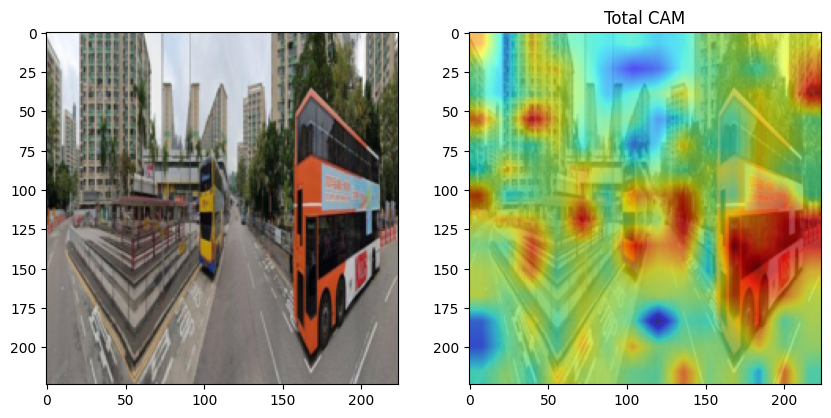

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_tensor[0].permute(1,2,0).cpu().numpy())
# ax[0].imshow(smoothed_cam, alpha=0.6, cmap='jet')
# ax[0].set_title('Smoothed CAM')
ax[1].imshow(input_tensor[0].permute(1,2,0).cpu().numpy())
ax[1].imshow(total_cam.mean(axis=0), alpha=0.6, cmap='jet')
ax[1].set_title('Total CAM')

In [12]:
nodes, _ = get_graph_node_names(model)
print(nodes)

['x', 'extractor.model.getattr', 'extractor.model.getitem', 'extractor.model.getitem_1', 'extractor.model.getitem_2', 'extractor.model.eq', 'extractor.model._assert', 'extractor.model.eq_1', 'extractor.model._assert_1', 'extractor.model.floordiv', 'extractor.model.floordiv_1', 'extractor.model.conv_proj', 'extractor.model.mul', 'extractor.model.reshape', 'extractor.model.permute', 'extractor.model.getattr_1', 'extractor.model.getitem_3', 'extractor.model.extractor_model_class_token', 'extractor.model.expand', 'extractor.model.cat', 'extractor.model.dim', 'extractor.model.eq_2', 'extractor.model._assert_2', 'extractor.model.extractor_model_encoder_pos_embedding', 'extractor.model.add', 'extractor.model.encoder.dropout', 'extractor.model.dim_1', 'extractor.model.eq_3', 'extractor.model._assert_3', 'extractor.model.encoder.layers.encoder_layer_0.ln', 'extractor.model.encoder.layers.encoder_layer_0.self_attention', 'extractor.model.getitem_4', 'extractor.model.encoder.layers.encoder_layer_

<Axes: ylabel='Density'>

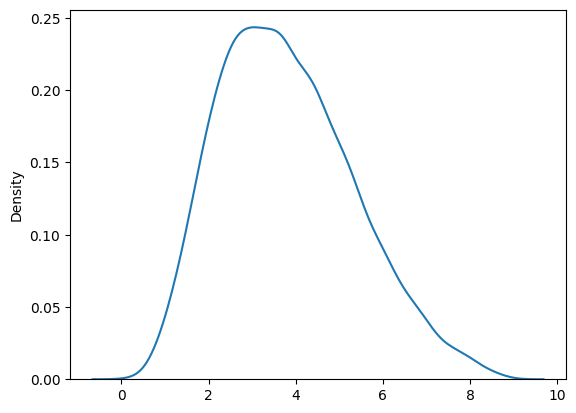

In [11]:
import seaborn as sns
sns.kdeplot(final_outputs)

In [22]:
data['final_outputs'] = final_outputs

In [36]:
data['log_final_outputs'] = np.log(data['final_outputs'])
data['log_score'] = np.log(data['Score'])

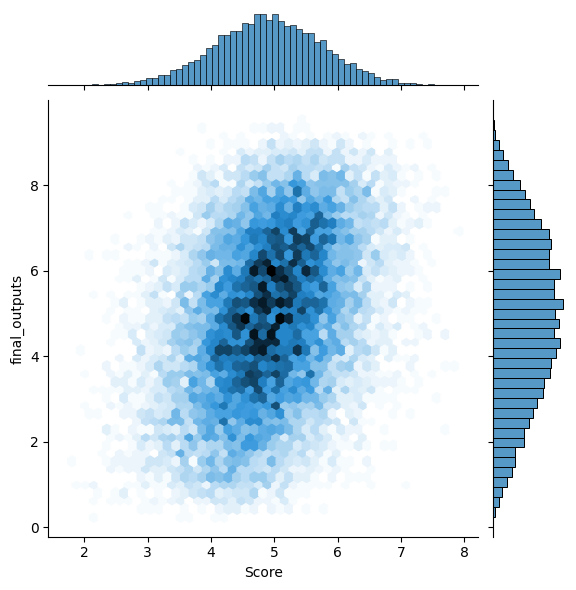

In [46]:
# sns.scatterplot(data=data, x='Score', y='final_outputs')
# sns.jointplot(data=data, x='Score', y='final_outputs', line_kws={"label":f"R2 Score: {r2_score(data['Score'], data['final_outputs']):.2f}"})
sns.jointplot(data=data, x='Score', y='final_outputs', kind='hex')
# plt.legend()

## multimodal

In [42]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from multimodal_safety_train import ImageExtractor, TextExtractor, Adaptor, Classifier, Mixer, MultiModalModel

import pandas as pd
from glob import glob
from PIL import Image
import torchvision.transforms as transforms
# from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torch.utils.data import Dataset
import transformers
import numpy as np

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [48]:
pkl_path = "/data2/cehou/LLM_safety/img_text_data/finished/dataset_60_female_HongKong_traffic accident_all_4685.pkl"
data = pd.read_pickle(pkl_path)

In [65]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/multimodal/diff_concat_20241230/lr_1e-05_adaptor_output_dim_256_mix_process_concat/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()

class MultimodalSafetyPerceptionDataset(Dataset):
    def __init__(self, data, tokenizer=None, transform=None, paras=None,SVI_type='placepulse'):
        """
        Args:
            data (list or np.array): List or array of data samples.
            labels (list or np.array): List or array of labels corresponding to the data samples.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.captions = list(self.data['text_description_short'])   
        if tokenizer == 'Bert':
            self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
        elif tokenizer == 'GPT2':
            self.tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
        elif tokenizer == 'DistilBert':
            self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        self.transform = transform

        self.paras = paras
        self.SVI_type = SVI_type
        if SVI_type == 'GSV':
            self.img_path = "/data2/cehou/LLM_safety/GSV/HK_imgs"
        elif SVI_type == 'placepulse':
            self.img_path = "/data2/cehou/LLM_safety/PlacePulse2.0/photo_dataset/final_photo_dataset/"
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):        
        # image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
        # image = Image.fromarray(image)
        if self.SVI_type == 'placepulse':
            image_path = f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"
            image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
        elif self.SVI_type == 'GSV':
            image_id = self.data.iloc[idx]['Image_ID']
            for i,angle in enumerate([0, 90, 180, 270]):
                image_path = f"{self.img_path}/{image_id[0]}/{image_id[1]}/{image_id}_{angle}.jpg"
                if i == 0:
                    image = np.array(Image.open(image_path))
                else:
                    image = np.concatenate((image, np.array(Image.open(image_path))), axis=1)
        image = Image.fromarray(image)
        if self.paras['train_type'] == 'classification':
            label = self.data.iloc[idx]["label"]
            # label = label * 100 // 5
        elif self.paras['train_type'] == 'regression':
            label = self.data.iloc[idx]["Score"]
            
        if self.transform:            
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        tokenized_text = self.tokenizer(
            self.data.iloc[idx]["text_description_short"], padding=True, truncation=True, max_length=512
        )
        encoded_descriptions =  torch.tensor(tokenized_text['input_ids']).float() 
        attention_mask = torch.tensor(tokenized_text['attention_mask']).float()
        # Pad the sequence with zeros to make it 512 in length

        padding_length = 512 - len(encoded_descriptions)
        if padding_length > 0:
            encoded_descriptions = torch.cat((encoded_descriptions, torch.zeros(padding_length)), dim=0)
            attention_mask = torch.cat((attention_mask, torch.zeros(padding_length)), dim=0)
        elif padding_length < 0:
            encoded_descriptions = encoded_descriptions[:512]
            attention_mask = attention_mask[:512]

        # encoded_descriptions转换为long
        # encoded_descriptions = torch.nn.Linear(encoded_descriptions.size(0), 512)(encoded_descriptions)

        return image, (encoded_descriptions, attention_mask), label



def get_transforms(resize_size):
    return transforms.Compose(
        [
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )    


def multimodal_model_test(model, test_loader, LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_preds = []
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, (description, attention_mask), target in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            data, description, attention_mask, target = data.cuda(), description.cuda().long(), attention_mask.cuda().long(), target.cuda().long()
            output = model(data, description, attention_mask)  # 获取模型输出
            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_outputs.append(output)
    
    all_outputs = torch.cat(all_outputs, dim=0)
    
    # 计算混淆矩阵
    # cm = confusion_matrix(all_labels, all_preds)
    # # 计算F1分数
    # f1 = f1_score(all_labels, all_preds, average='weighted')
    return all_outputs, all_labels


In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_extractor = ImageExtractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
text_extractor = TextExtractor(pretrained_model=parameters['text_feature_extractor']) # [128, 768]
image_adaptor = Adaptor(input_dim=parameters['image_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
text_adaptor = Adaptor(input_dim=parameters['text_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='text') # [128, 256]
mixer = Mixer(output_dim=parameters['mixer_output_dim'], process=parameters['mix_process']) # [128, 512]
classifier = Classifier(input_dim=parameters['mixer_output_dim'], num_classes=parameters['num_classes']) # [128, 2]

multimodal_model = MultiModalModel(image_extractor, text_extractor, image_adaptor, text_adaptor, mixer, classifier).to(device)

# Load the saved model parameters
multimodal_model.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)

<All keys matched successfully>

In [67]:
class ImageFeatureGenerater(nn.Module):
    def __init__(self, image_extractor, image_adaptor):
        super(ImageFeatureGenerater, self).__init__()
        self.image_extractor = image_extractor
        self.image_adaptor = image_adaptor

    def forward(self, x_img):
        # 先通过extractor提取特征，再通过adaptor处理，最后分类
        img_features = self.image_extractor(x_img)
        adapted_img_features = self.image_adaptor(img_features)
        return adapted_img_features

class TextFeatureGenerater(nn.Module):
    def __init__(self, text_extractor, text_adaptor):
        super(TextFeatureGenerater, self).__init__()
        self.text_extractor = text_extractor
        self.text_adaptor = text_adaptor

    def forward(self, x_text, attention_mask):
        # 先通过extractor提取特征，再通过adaptor处理，最后分类
        text_features = self.text_extractor(x_text, attention_mask)
        adapted_text_features = self.text_adaptor(text_features)
        return adapted_text_features

image_feature_generater = ImageFeatureGenerater(image_extractor, image_adaptor)
text_feature_generater = TextFeatureGenerater(text_extractor, text_adaptor)

image_feature_generater.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)
text_feature_generater.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_extractor.model.class_token', 'image_extractor.model.conv_proj.weight', 'image_extractor.model.conv_proj.bias', 'image_extractor.model.encoder.pos_embedding', 'image_extractor.model.encoder.layers.encoder_layer_0.ln_1.weight', 'image_extractor.model.encoder.layers.encoder_layer_0.ln_1.bias', 'image_extractor.model.encoder.layers.encoder_layer_0.self_attention.in_proj_weight', 'image_extractor.model.encoder.layers.encoder_layer_0.self_attention.in_proj_bias', 'image_extractor.model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight', 'image_extractor.model.encoder.layers.encoder_layer_0.self_attention.out_proj.bias', 'image_extractor.model.encoder.layers.encoder_layer_0.ln_2.weight', 'image_extractor.model.encoder.layers.encoder_layer_0.ln_2.bias', 'image_extractor.model.encoder.layers.encoder_layer_0.mlp.0.weight', 'image_extractor.model.encoder.layers.encoder_layer_0.mlp.0.bias', 'image_extractor.model.encoder.layer

In [68]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# placepulse_data = pd.read_csv("/data2/cehou/LLM_safety/img_text_data/baseline/tidyed/dataset_baseline_baseline_baseline_baseline_9030_withlabel.csv")
# placepulse_data['label'] = 1
# placepulse_data = placepulse_data.rename(columns={"panoid": "Image_ID"})
pkl_path = "/data2/cehou/LLM_safety/img_text_data/finished/dataset_60_female_HongKong_traffic accident_all_4685.pkl"
data = pd.read_pickle(pkl_path)

transform = get_transforms((224,224))
data = data.rename(columns={'text_description_age': 'text_description_short',
                                            'panoid': 'Image_ID',})
data['label'] = 1
total_dataset = MultimodalSafetyPerceptionDataset(data, tokenizer=parameters['text_feature_extractor'], transform=transform, paras=parameters, SVI_type="GSV")
total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=parameters['batch_size'])

multimodal_model.eval()  # 切换到评估模式
all_outputs, all_labels = multimodal_model_test(multimodal_model, total_loader)

100%|██████████| 37/37 [01:20<00:00,  2.16s/it]


In [69]:
all_outputs_normalized = F.softmax(all_outputs, dim=1)
final_outputs = all_outputs_normalized[:,0]* 0 + all_outputs_normalized[:,1] * 10
final_outputs = final_outputs.cpu().numpy()
# placepulse_data['final_outputs'] = final_outputs

<Axes: ylabel='Density'>

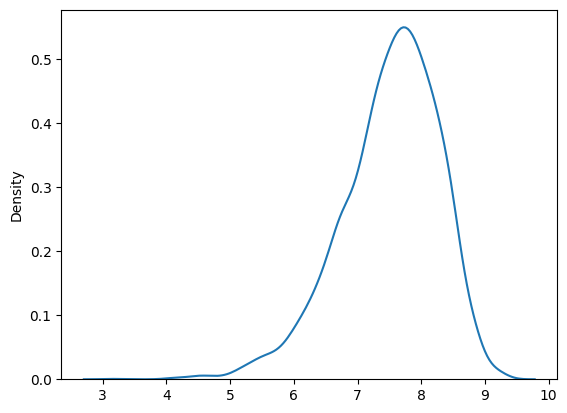

: 

In [70]:
sns.kdeplot(final_outputs)

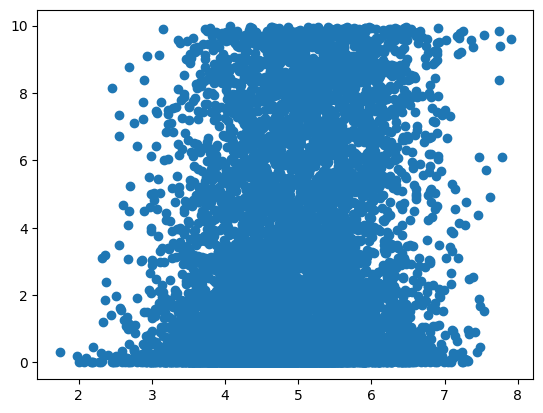

In [18]:
plt.scatter(placepulse_data['Score'], placepulse_data['final_outputs'])

<Axes: >

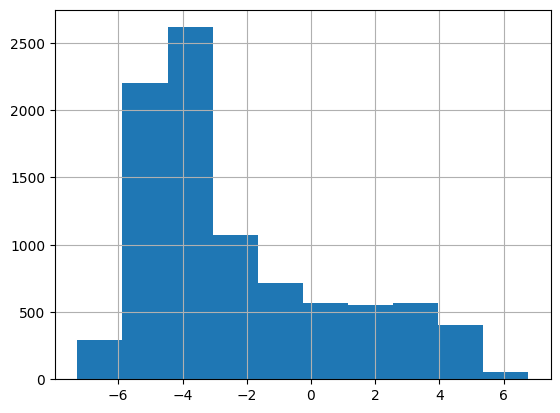

In [19]:
(placepulse_data['final_outputs'] - placepulse_data['Score']).hist()

In [6]:

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# # female_30_data = pd.read_pickle("/data2/cehou/LLM_safety/img_text_data/finished/dataset_30_female_HongKong_traffic accident_GSV_all_4974.pkl")
# female_30_data = pd.read_pickle("/data2/cehou/LLM_safety/img_text_data/finished/dataset_30_female_HongKong_traffic accident_GSV_all_4974.pkl")

# female_30_data['label'] = 1
# female_30_data = female_30_data.rename(columns={"panoid": "Image_ID"})
# transform = get_transforms((224,224))
# one_dataset = MultimodalSafetyPerceptionDataset(female_30_data[:10], tokenizer=parameters['text_feature_extractor'], transform=transform, paras=parameters, SVI_type="GSV")
# total_dataset = MultimodalSafetyPerceptionDataset(female_30_data.iloc[100:300], tokenizer=parameters['text_feature_extractor'], transform=transform, paras=parameters, SVI_type="GSV")

# one_loader = torch.utils.data.DataLoader(one_dataset, batch_size=parameters['batch_size'])
# total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=parameters['batch_size'])


# male_30_data = pd.read_pickle("/data2/cehou/LLM_safety/img_text_data/finished/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl")
# male_30_data['label'] = 1
# male_30_data = male_30_data.rename(columns={"panoid": "Image_ID"})
# transform = get_transforms((224,224))
# male_one_dataset = MultimodalSafetyPerceptionDataset(male_30_data[:10], tokenizer=parameters['text_feature_extractor'], transform=transform, paras=parameters, SVI_type="GSV")
# male_total_dataset = MultimodalSafetyPerceptionDataset(male_30_data.iloc[100:300], tokenizer=parameters['text_feature_extractor'], transform=transform, paras=parameters, SVI_type="GSV")

# male_one_loader = torch.utils.data.DataLoader(male_one_dataset, batch_size=parameters['batch_size'])
# male_total_loader = torch.utils.data.DataLoader(male_total_dataset, batch_size=parameters['batch_size'])

UnpicklingError: invalid load key, 'm'.

In [29]:
image_feature_generater.eval()  # 切换到评估模式
text_feature_generater.eval()  # 切换到评估模式

female_all_img_features = []
female_all_text_features = []
female_labels = []
with torch.no_grad():  # 关闭梯度计算，节省内存
    for data, (description, attention_mask), target in total_loader:
        data, description, attention_mask, target = data.cuda(), description.cuda().long(), attention_mask.cuda().long(), target.cuda().long()
        img_feature = image_feature_generater(data)  # 获取模型输出
        text_feature = text_feature_generater(description, attention_mask)
        female_all_img_features.extend(img_feature.cpu().numpy())
        female_all_text_features.extend(text_feature.cpu().numpy())
        female_labels.extend(target.cpu().numpy())

female_all_img_features = np.array(female_all_img_features)
female_all_text_features = np.array(female_all_text_features)

male_all_img_features = []
male_all_text_features = []
male_labels = []

with torch.no_grad():  # 关闭梯度计算，节省内存
    for data, (description, attention_mask), target in male_total_loader:
        data, description, attention_mask, target = data.cuda(), description.cuda().long(), attention_mask.cuda().long(), target.cuda().long()
        img_feature = image_feature_generater(data)  # 获取模型输出
        text_feature = text_feature_generater(description, attention_mask)
        male_all_img_features.extend(img_feature.cpu().numpy())
        male_all_text_features.extend(text_feature.cpu().numpy())
        male_labels.extend(target.cpu().numpy())

male_all_img_features = np.array(male_all_img_features)
male_all_text_features = np.array(male_all_text_features)

generate label

In [58]:
male_all_preds, male_all_labels = multimodal_model_test(multimodal_model, male_total_loader)
male_all_outputs_normalized = F.softmax(male_all_preds, dim=1)
male_final_outputs = male_all_outputs_normalized[:,0]* 0 + male_all_outputs_normalized[:,1] * 10
male_final_outputs = male_final_outputs.cpu().numpy()

female_all_preds, female_all_labels = multimodal_model_test(multimodal_model, total_loader)
female_all_outputs_normalized = F.softmax(female_all_preds, dim=1)
female_final_outputs = female_all_outputs_normalized[:,0]* 0 + female_all_outputs_normalized[:,1] * 10
female_final_outputs = female_final_outputs.cpu().numpy()

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

male_all_features = np.concatenate([male_all_img_features, male_all_text_features], axis=1)
male_labels = [1 if i > 5 else 0 for i in male_final_outputs]
female_all_features = np.concatenate([female_all_img_features, female_all_text_features], axis=1)
female_labels = [1 if i > 5 else 0 for i in female_final_outputs]

# Train a Random Forest classifier
male_rf = RandomForestClassifier(n_estimators=100, random_state=42)
male_rf.fit(male_all_features, male_labels)
male_predictions = male_rf.predict(male_all_features)

# Evaluate the model
accuracy = accuracy_score(male_labels, male_predictions)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(male_labels, male_predictions))

female_rf = RandomForestClassifier(n_estimators=100, random_state=42)
female_rf.fit(female_all_features, female_labels)
female_predictions = female_rf.predict(female_all_features)

# Evaluate the model
accuracy = accuracy_score(female_labels, female_predictions)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(female_labels, female_predictions))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       137

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



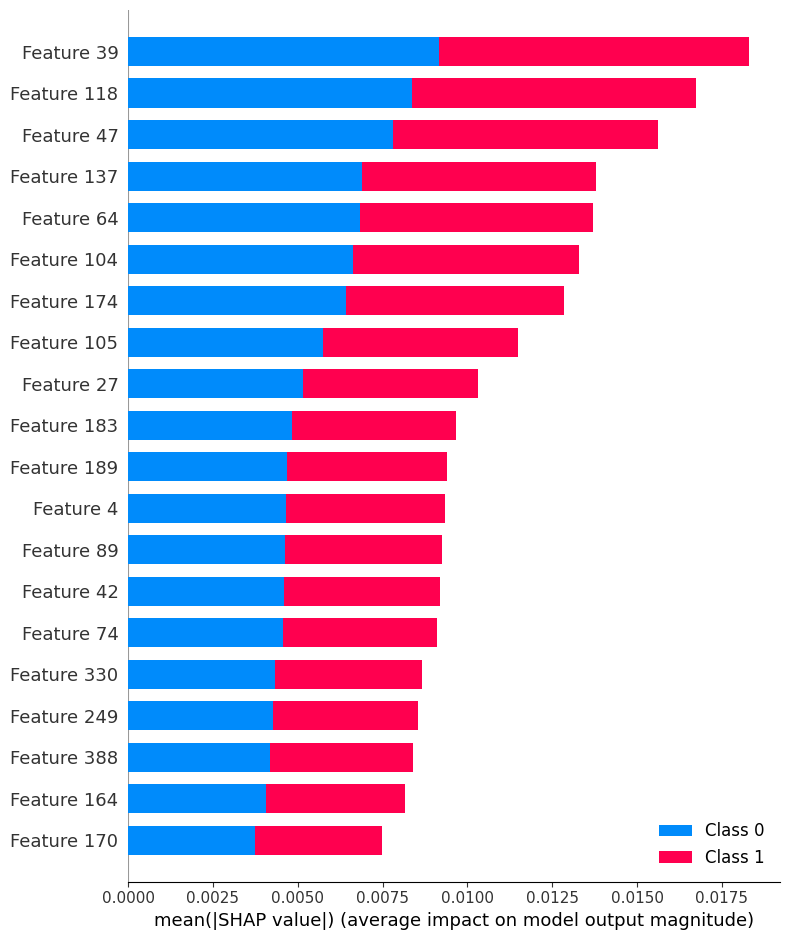

In [66]:
import shap

# 创建 SHAP explainer
explainer = shap.TreeExplainer(male_rf)

# 计算 SHAP 值
shap_values = explainer.shap_values(male_all_features)

# 绘制 SHAP summary plot
shap.summary_plot(shap_values, male_all_features)

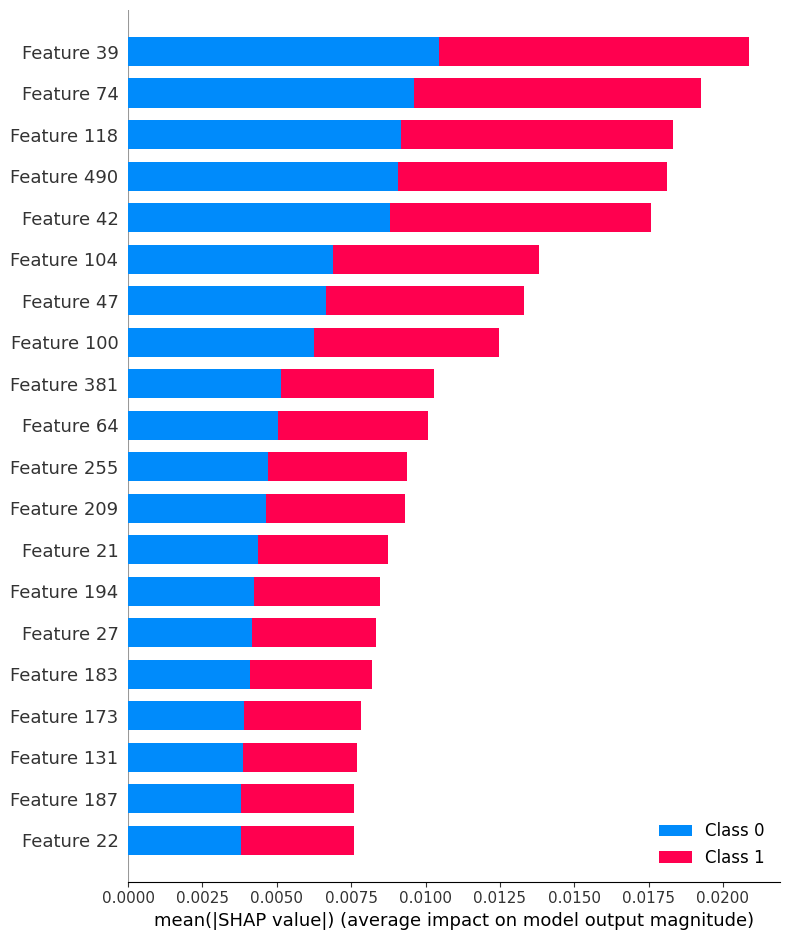

In [67]:
# 创建 SHAP explainer
explainer = shap.TreeExplainer(female_rf)

# 计算 SHAP 值
female_shap_values = explainer.shap_values(female_all_features)

# 绘制 SHAP summary plot
shap.summary_plot(female_shap_values, female_all_features)

In [74]:
dim_diff = shap_values[0][:,0] - female_shap_values[0][:,0]
dim_diff_variance = np.var(dim_diff)
print(f"Variance of dim_diff: {dim_diff_variance}")

Variance of dim_diff: 7.454160098618076e-06


In [75]:
dim_diff_list = []
for i in range(512):
    dim_diff = shap_values[0][:,i] - female_shap_values[0][:,0]
    dim_diff_variance = np.var(dim_diff)
    dim_diff_list.append(dim_diff_variance)

In [ ]:
sns.kdeplot(dim_diff_list)

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
female_feature_pca = pca.fit_transform(female_all_text_features[256:])
male_feature_pca = pca.fit_transform(male_all_text_features[256:])
sns.scatterplot(x=female_feature_pca[:,0], y=male_feature_pca[:,1])
sns.scatterplot(x=male_feature_pca[:,0], y=male_feature_pca[:,1])

plt.title("PCA of Fused Feature")

ValueError: Found array with 0 sample(s) (shape=(0, 256)) while a minimum of 1 is required by PCA.

In [1]:
import pandas as pd
from scipy.stats import norm

data = pd.read_csv("/data2/cehou/LLM_safety/img_text_data/baseline/tidyed/dataset_baseline_baseline_baseline_baseline_9030_withlabel.csv")
mu, std = norm.fit(data['Score'])
std_threshold = 3
data['label'] = 0
data.loc[data[data['Score'] > mu + std_threshold * std].index, 'label'] = 1
data.loc[data[data['Score'] < mu - std_threshold * std].index, 'label'] = -1

In [7]:
a = data.iloc[:5,:]
b = data.iloc[6:10,:]

pd.concat([a, b], axis=0)

,GSV_idx,Image_ID,GSV_path,text_description,age,gender,location,event,Score,label,text_description_short,Category
0,49,50f55e9afdc9f065f0004d84,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,4.919817,0,The panoramic street view image shows a street...,safety
1,50,50f55e9bfdc9f065f0004d92,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,5.406606,0,The street scene in the panoramic street view ...,safety
2,51,50f55e9cfdc9f065f0004da9,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,4.219841,0,The panoramic street view image shows a tree-l...,safety
3,52,50f55e9cfdc9f065f0004daa,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,5.941633,0,The street scene in the panoramic street view ...,safety
4,53,50f55e9cfdc9f065f0004dae,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,4.258011,0,The panoramic street view image shows a street...,safety
6,55,50f55e9dfdc9f065f0004dca,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,5.567581,0,The panoramic street view image shows a quiet ...,safety
7,56,50f55eadfdc9f065f0004dd0,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,4.898028,0,The panoramic street view image shows a tree-l...,safety
8,57,50f55eaefdc9f065f0004de3,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,5.562937,0,The street scene in the panoramic street view ...,safety
9,58,50f55eaefdc9f065f0004de9,/data2/cehou/LLM_safety/PlacePulse2.0/photo_da...,[INST] Please design a street safety perceptio...,baseline,baseline,baseline,baseline,5.073518,0,The panoramic street view image shows a quiet ...,safety


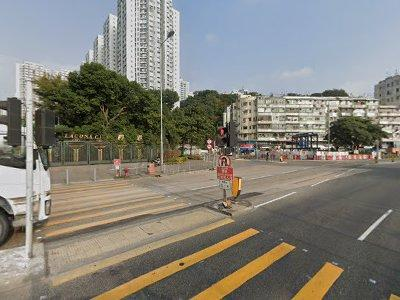

In [38]:
from PIL import Image

panoid = HK_data.iloc[12]['panoid']
img_path = f"/data2/cehou/LLM_safety/GSV/HK_imgs/{panoid[0]}/{panoid[1]}/{panoid}_90.jpg"
img = Image.open(img_path)
img

In [ ]:
import pandas as pd
import geopandas as gpd
female = pd.read_csv("/data2/cehou/LLM_safety/HK_shp_files/30_males/30_females.csv")
male = pd.read_csv("/data2/cehou/LLM_safety/HK_shp_files/30_males/30_males.csv")
baseline = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")
baseline['gender'] = 'baseline'
baseline = baseline.rename(columns={'final_outp':'final_outputs'})

In [38]:
concated = pd.concat([male[['Image_ID','gender', 'final_outputs']],
           female[['Image_ID','gender', 'final_outputs']],
           baseline[['Image_ID','gender', 'final_outputs']]]).reset_index(drop=True)


<Axes: xlabel='final_outputs', ylabel='Density'>

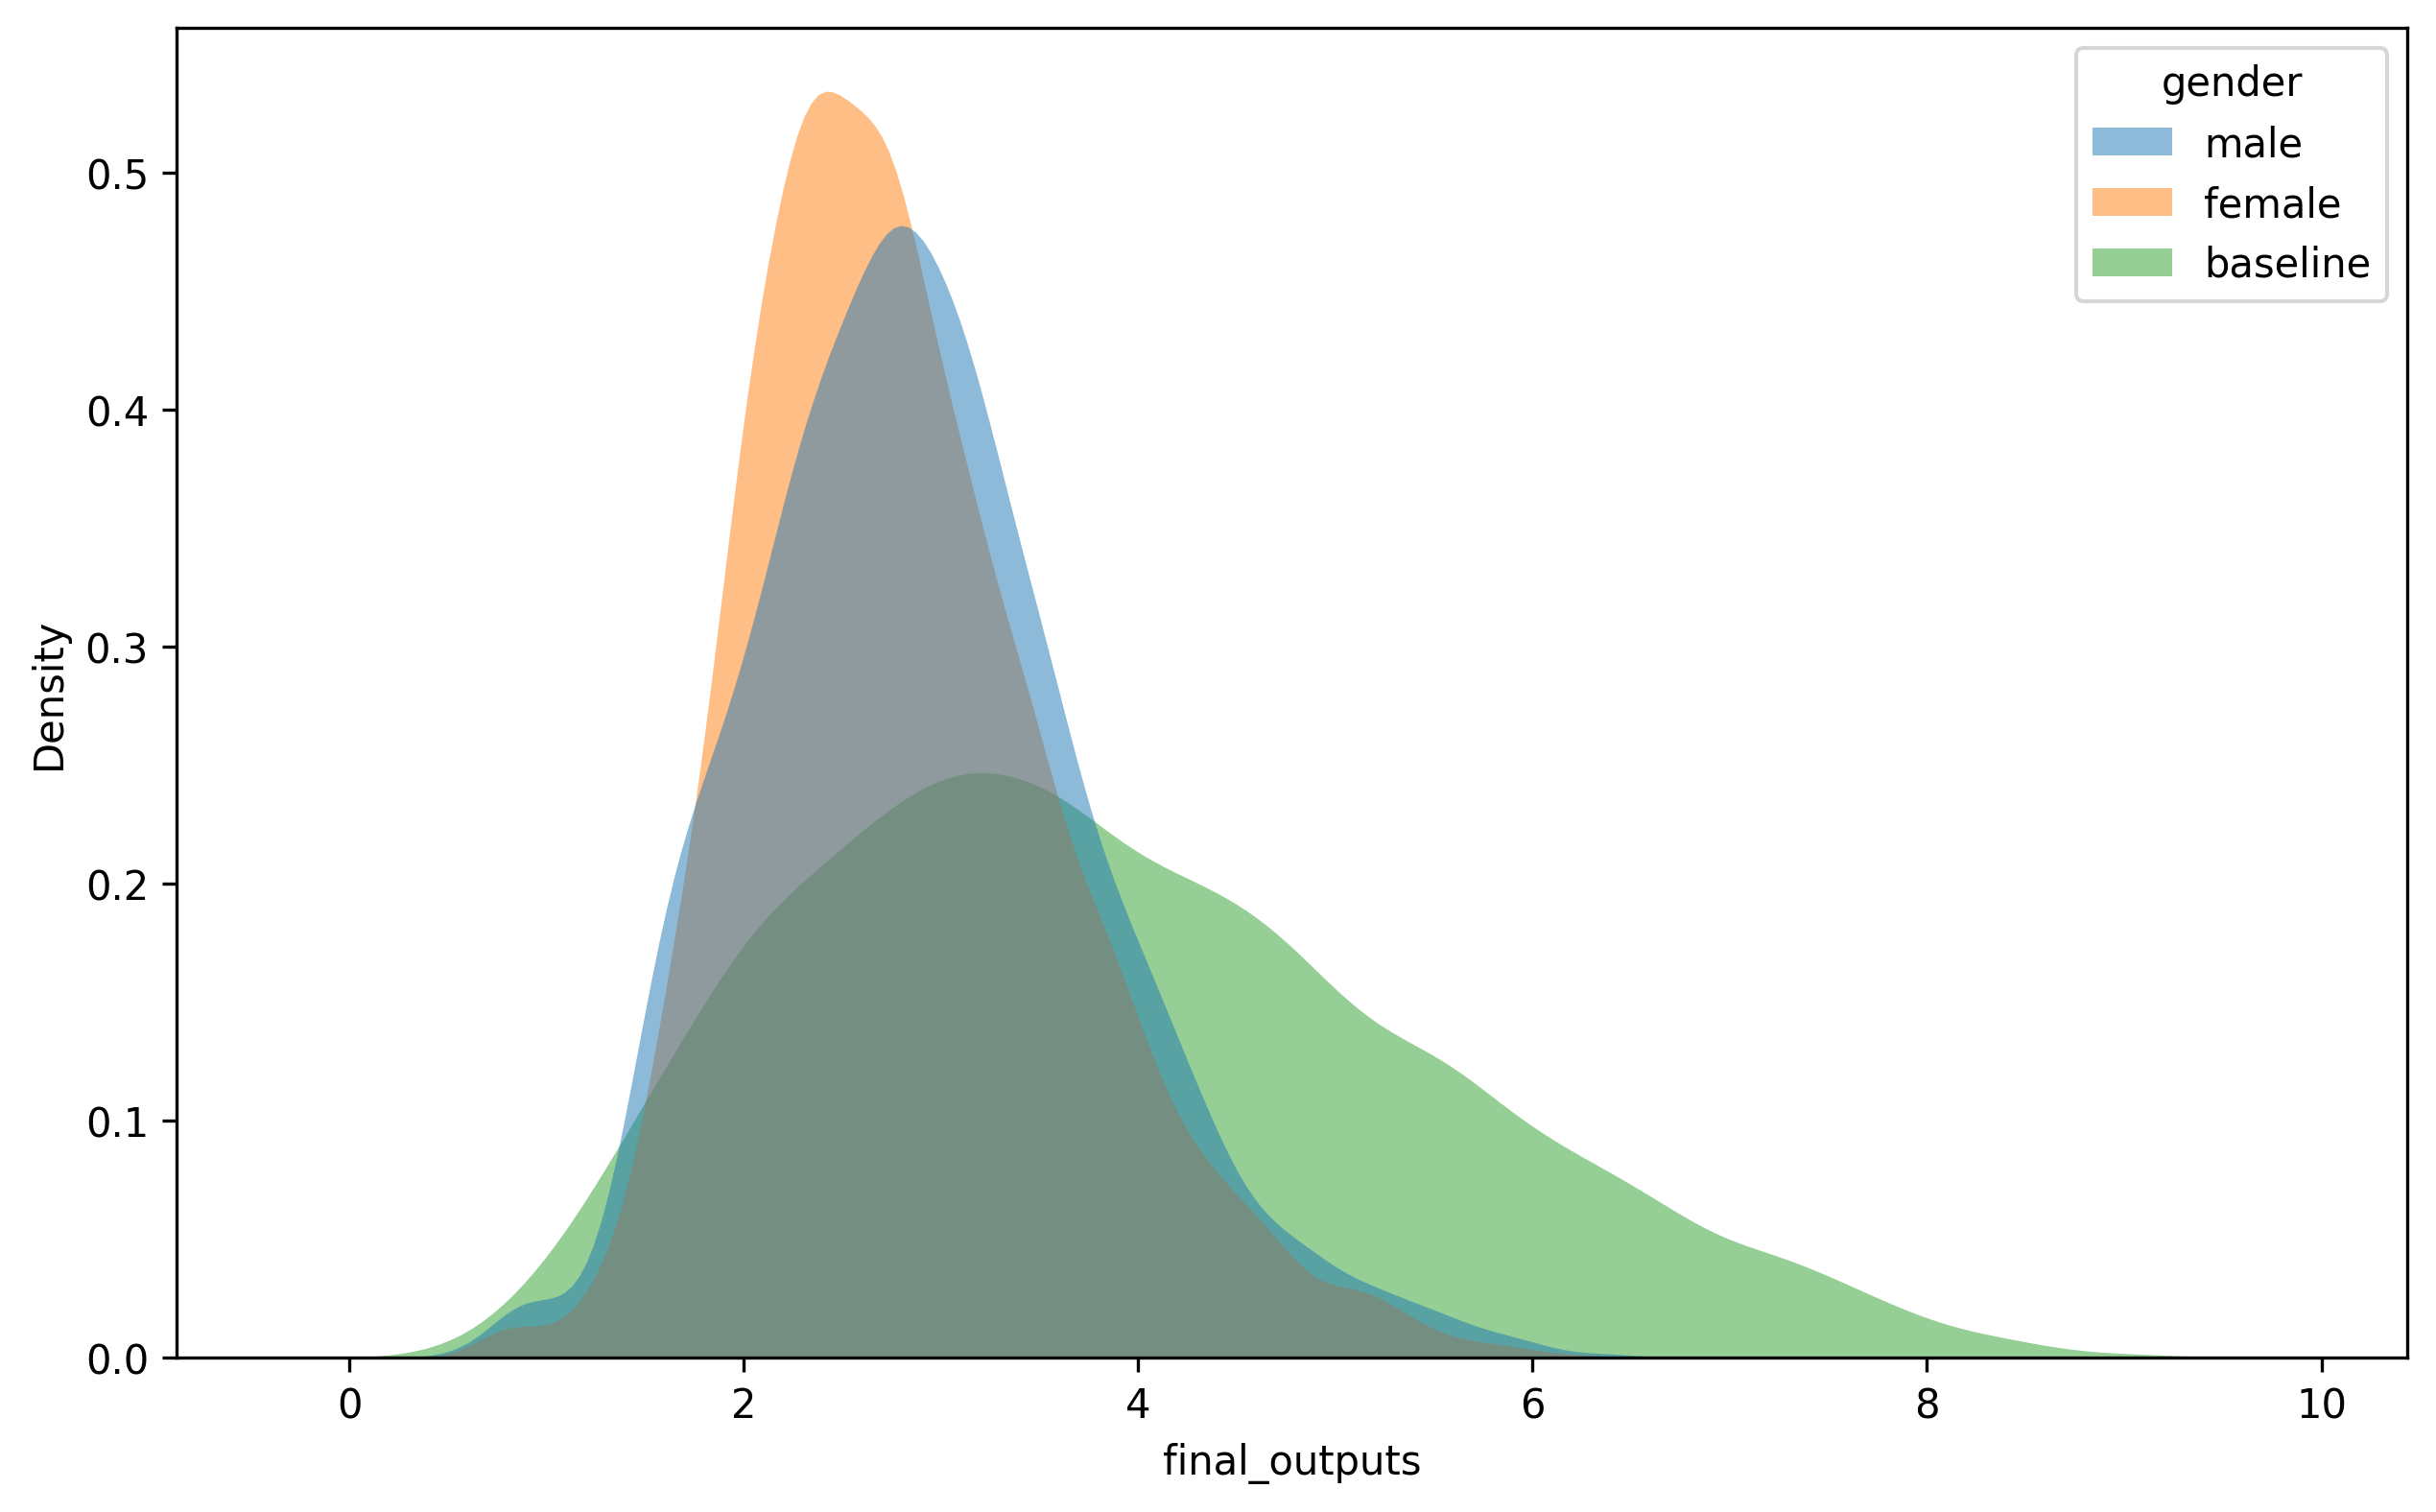

In [48]:
fig, ax = plt.subplots(figsize=(10,6),dpi=300)
sns.kdeplot(
   data=concated, x="final_outputs", hue="gender",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, ax=ax
)

In [12]:
import pandas as pd
HK_data = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl')
HK_data

,GSV_idx,panoid,age,gender,location,event,text_description_all,text_description_age,text_description_gender,text_description_location
0,0,pLuKvPlHrMPC7HbiwdWJsQ,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old individual, several factors ...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...
1,1,9N3G-AjC5a_k_cjbYWTuXQ,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
2,2,vBpRyVLbY1WpqvrM11TCaw,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...
3,3,ksvoYZaPS1tOj9flVw2rPg,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old individual, several factors ...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
4,4,WkHeZe_Exxcwry_UbS7bZw,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
...,...,...,...,...,...,...,...,...,...,...
4707,4984,B6jXBp8HViBTNANUascVbg,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For 30, the factors in the image that could im...",When evaluating the safety perception of speci...,When discussing the safety perception in Hong ...
4708,4985,E1hFilX1FmwMioq1o-hgKw,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old individual, several factors ...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
4709,4986,dqEW3eJiJmJJgIIuFD2PjQ,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...
4710,4987,UzH6unzGLtuSsTtOYYvfXA,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...


In [5]:
HK_data.iloc[0]['text_description_all'][0]

'[INST]  \n["Please design a car accident-focused street safety perception system list briefly and include different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Please pay special attention to the fact that people of different ages and genders may have different perceptions and reactions. Note that we cannot provide subjective information about residents\' personal experiences, so look for key points from the objective environment, please answer this question within 300 words."] [/INST] Designing a car accident-focused street safety perception system involves considering various elements of the urban environment that can be captured in Street View images. Here are some key points to consider:\n\n1. **Traffic Signs and Signals**: These are crucial for regulating traffic and ensuring safety. In the image, there are traffic lights and signs that provide guidan

In [10]:
HK_data = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl')
HK_data['label'] = 1
HK_data.rename(columns={'panoid':'Image_ID'}, inplace=True)
HK_data = HK_data[~HK_data['Image_ID'].str.startswith('AF1Q')]
transform = get_transforms((224,224))
parameters['batch_size'] = 256
HK_dataset = MultimodalSafetyPerceptionDataset(HK_data, transform=transform, paras=parameters, SVI_type="GSV")
HK_loader = torch.utils.data.DataLoader(HK_dataset, batch_size=parameters['batch_size'])
all_outputs, all_labels = multimodal_model_test(multimodal_model, HK_loader)

# HK_data = pd.read_pickle(HK_dataset)
# HK_data.to_csv('/data2/cehou/LLM_safety/PlacePulse2.0/HK_metadata.csv')

KeyError: 'text_description_short'

In [ ]:
all_outputs_normalized = F.softmax(all_outputs, dim=1)
final_outputs = all_outputs_normalized[:,0]* 0 + all_outputs_normalized[:,1] * 10
final_outputs = final_outputs.cpu().numpy()
HK_data['final_outputs'] = final_outputs

In [3]:
import geopandas as gpd
HK_safety_perception_sampled = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")


<Axes: >

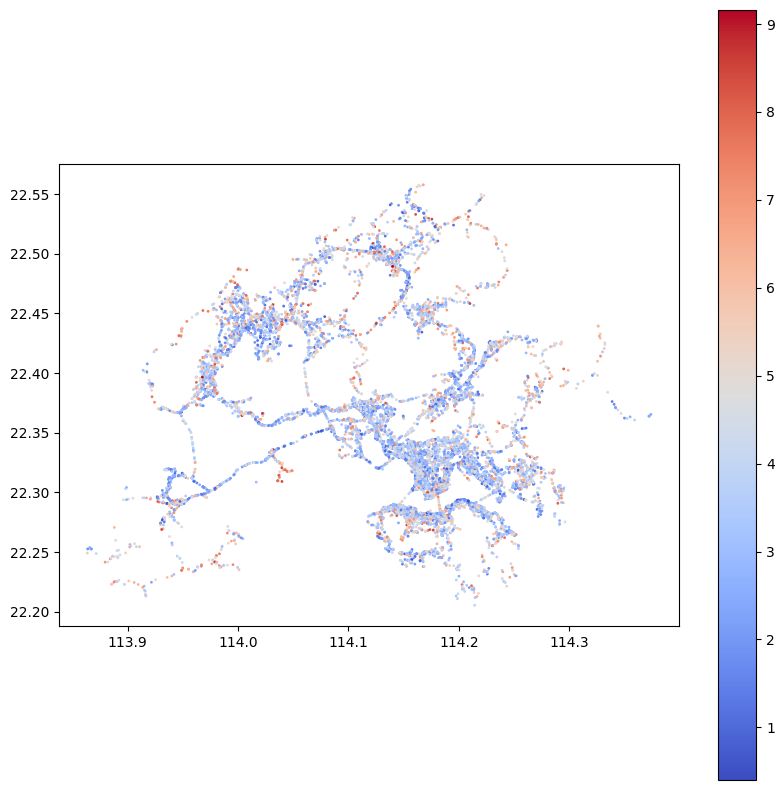

In [7]:
HK_safety_perception_sampled.plot(column='final_outp', cmap='coolwarm', legend=True, markersize=1, figsize=(10,10))

In [ ]:
HK_roads = gpd.read_file("/data_nas/GoogleSV/metadata/China/HongKong/edges.shp")
HK_safety_perception_sampled = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")
HK_roads = HK_roads.reset_index().rename(columns={'index':'id'})
# HK_safety_perception_sampled.drop(['geometry'], axis=1, inplace=True)
HK_road_merge = HK_safety_perception_sampled.merge(HK_roads[['id', 'geometry']], on='id', how='left')
HK_road_merge = HK_road_merge.drop(['Unnamed_ 0','geometry_x'],axis=1).rename(columns={'geometry_y':'geometry'})

In [58]:
# Group by 'id' and calculate the mean of 'final_outp'
average_final_outp = HK_road_merge.groupby('id')['final_outp'].mean().reset_index()

# Rename the column to indicate it's an average
average_final_outp.rename(columns={'final_outp': 'average_final_outp'}, inplace=True)
HK_road_merge_new = HK_road_merge.merge(average_final_outp, on='id', how='inner')
HK_road_merge_new = gpd.GeoDataFrame(HK_road_merge_new, crs='EPSG:4326', geometry='geometry')
HK_road_merge_new.drop_duplicates(subset=['id'], inplace=True)

In [63]:
HK_road_merge_new.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline_roads.shp")

/tmp/ipykernel_12116/3714306485.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  HK_road_merge_new.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline_roads.shp")


In [52]:
import geopandas as gpd
HK_data_gpd = gpd.GeoDataFrame(HK_data, geometry=gpd.points_from_xy(HK_data['lon'], HK_data['lat']))
HK_data_gpd.set_crs(epsg=4326, inplace=True)
# HK_data_gpd.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")

,Unnamed: 0,Image_ID,lat,lon,year,month,id,label,final_outputs,geometry
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119,POINT (114.12836 22.49864)
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859,POINT (114.26078 22.30919)
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743,POINT (114.15813 22.53986)
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057,POINT (113.97466 22.39433)
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885,POINT (114.19632 22.34371)
...,...,...,...,...,...,...,...,...,...,...
9986,9995,457895D8Y6Mr9hZLc_D0Bg,22.383804,114.196998,NaN,NaN,8618,1,3.138475,POINT (114.19700 22.38380)
9987,9996,fXN95evjM46lxpV1hfNw5g,22.462529,114.104716,2021.0,9.0,21713,1,7.635498,POINT (114.10472 22.46253)
9988,9997,uWW-8MfWvXxT9FS20Czoew,22.380430,113.970491,NaN,NaN,16585,1,1.810967,POINT (113.97049 22.38043)
9989,9998,oLFDyYZb0TbgH4xjc5wGdw,22.363614,114.014050,NaN,NaN,16190,1,5.119205,POINT (114.01405 22.36361)


In [1]:
import geopandas as gpd

gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")

,Unnamed_ 0,Image_ID,lat,lon,year,month,id,label,final_outp,geometry
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119,POINT (114.12836 22.49864)
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859,POINT (114.26078 22.30919)
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743,POINT (114.15813 22.53986)
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057,POINT (113.97466 22.39433)
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885,POINT (114.19632 22.34371)
...,...,...,...,...,...,...,...,...,...,...
9986,9995,457895D8Y6Mr9hZLc_D0Bg,22.383804,114.196998,NaN,NaN,8618,1,3.138475,POINT (114.19700 22.38380)
9987,9996,fXN95evjM46lxpV1hfNw5g,22.462529,114.104716,2021.0,9.0,21713,1,7.635498,POINT (114.10472 22.46253)
9988,9997,uWW-8MfWvXxT9FS20Czoew,22.380430,113.970491,NaN,NaN,16585,1,1.810967,POINT (113.97049 22.38043)
9989,9998,oLFDyYZb0TbgH4xjc5wGdw,22.363614,114.014050,NaN,NaN,16190,1,5.119205,POINT (114.01405 22.36361)


In [80]:
nodes, _ = get_graph_node_names(model)
# print(nodes)
feature_extracter = create_feature_extractor(model, return_nodes={'adaptor.layer_norm': 'features'})
all_outputs, all_labels = model_test(feature_extracter, train_loader)
valid_outputs, valid_labels = model_test(feature_extracter, valid_loader)

all_outputs, all_labels = all_outputs.cpu().numpy(), all_labels.cpu().numpy()
valid_outputs, valid_labels = valid_outputs.cpu().numpy(), valid_labels.cpu().numpy()

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# 创建随机森林分类器

def ml_classifier(train_data, train_labels, validate_data, validate_labels, ml_tools):
    if ml_tools == 'random forest':
        ml_model = RandomForestClassifier(n_estimators=500, random_state=42)
    if ml_tools == 'svm':
        ml_model = SVC(kernel='rbf', random_state=42) # kernel=‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    if ml_tools == 'logistic':
        ml_model = LogisticRegression(random_state=42)    
    if ml_tools == 'xgboost':
        ml_model = XGBClassifier(n_estimators=500, random_state=42)
    if ml_tools == 'mlp':
        ml_model = MLPClassifier(hidden_layer_sizes=(1024, 512), max_iter=100)
    
    ml_model.fit(train_data, train_labels)
    predictions = ml_model.predict(validate_data)
    accuracy = accuracy_score(validate_labels, predictions)
    print(f"Accuracy: {accuracy:.2f}, R2 score: {r2_score(validate_labels, predictions):.2f}, f1 score: {f1_score(validate_labels, predictions):.2f}")
    print(classification_report(validate_labels, predictions))
    return predictions

predictions = ml_classifier(all_outputs, all_labels, valid_outputs, valid_labels, 'xgboost')

Accuracy: 0.65, R2 score: -0.39, f1 score: 0.67
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       884
           1       0.64      0.70      0.67       869

    accuracy                           0.65      1753
   macro avg       0.65      0.65      0.65      1753
weighted avg       0.65      0.65      0.65      1753



: 

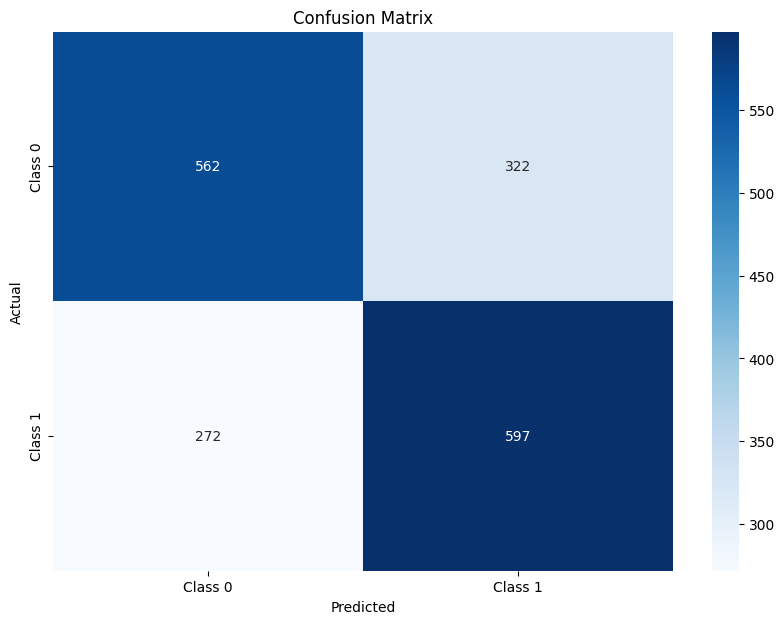

In [110]:
# 计算混淆矩阵
cm = confusion_matrix(valid_labels, predictions)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


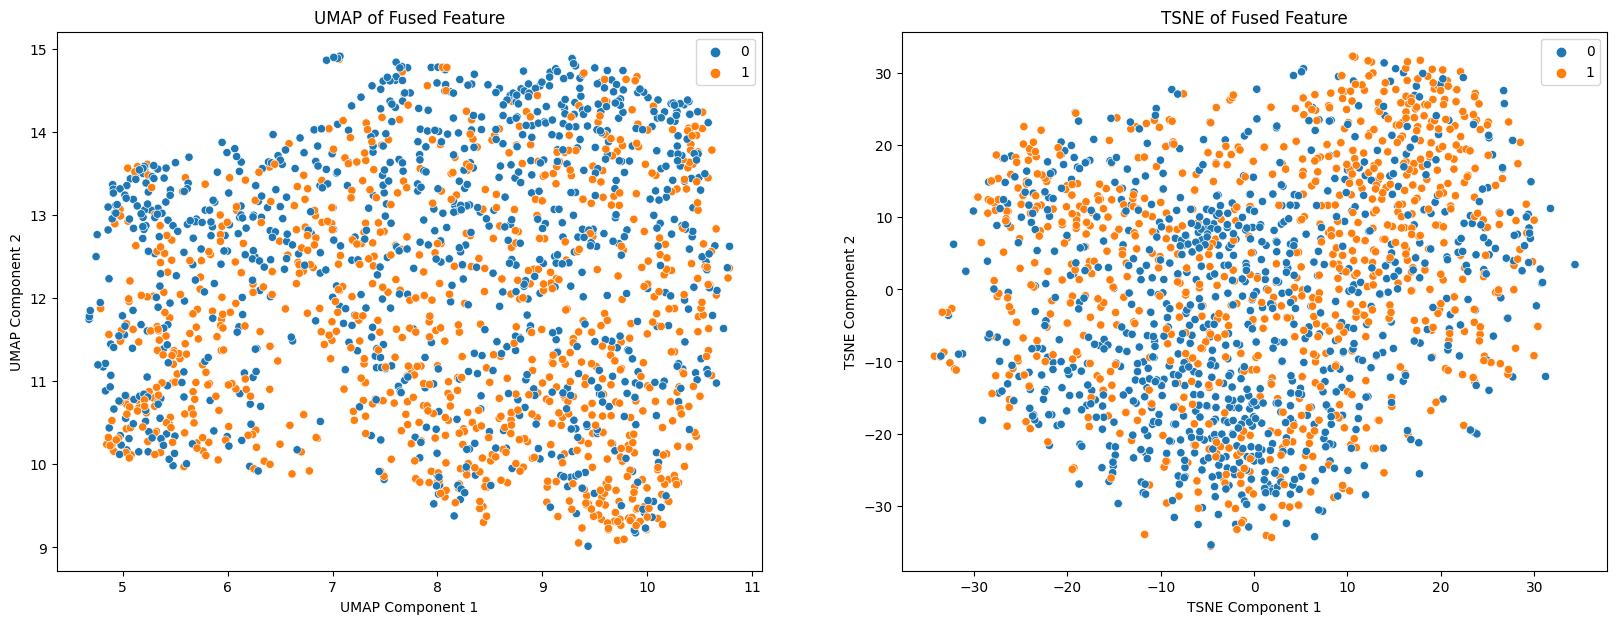

In [99]:
# %pip install umap-learn

import umap.umap_ as umap
from sklearn.manifold import TSNE

# 使用UMAP降维
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(valid_outputs)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(valid_outputs)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(x=umap_results[:,0], y=umap_results[:,1], hue=valid_labels, ax=ax[0])
ax[0].set_title("UMAP of Fused Feature")
ax[0].set_xlabel("UMAP Component 1")
ax[0].set_ylabel("UMAP Component 2")

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=valid_labels, ax=ax[1])
ax[1].set_title("TSNE of Fused Feature")
ax[1].set_xlabel("TSNE Component 1")
ax[1].set_ylabel("TSNE Component 2")
plt.show()


Text(0.5, 1.0, 'PCA of Fused Feature')

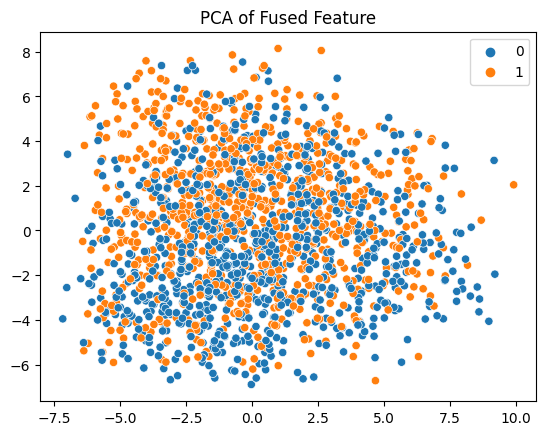

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
combined_feature_pca = pca.fit_transform(valid_outputs)

sns.scatterplot(x=combined_feature_pca[:,0], y=combined_feature_pca[:,1], hue=valid_labels)
plt.title("PCA of Fused Feature")

In [ ]:
# 使用shap计算每个维度的贡献
import shap

# 使用训练数据创建一个 SHAP explainer
explainer = shap.Explainer(mlp_classifier, X_train)
# explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_valid)

shap_values_overall = shap_values[0] + shap_values[1]
shap_values_sum = shap_values_overall.sum(axis=0).reshape(-1, 1)
print(f"image contribution: {shap_values_sum[:256].sum() / shap_values_sum.sum():.02%}, text contribution: {shap_values_sum[256:].sum() / shap_values_sum.sum():.02%}")

# 绘制 SHAP summary plot
# shap.summary_plot(shap_values, X_valid, feature_names=[f'Feature {i}' for i in range(X_valid.shape[1])])

In [ ]:


# # Example usage
# image_encoder = ImageEncoder(cfg_paras)
# text_encoder = TextEncoder(cfg_paras)
# fusion_model = AttentionalFeatureFusion(image_dim=cfg_paras['image_embedding'], text_dim=cfg_paras['text_embedding'], projection_dim=cfg_paras['projection_dim'])

# # Assuming we have image and text inputs
# image_input = torch.randn(1, 3, 112, 112).to(cfg_paras['device'])
# text_input_ids = torch.tensor([[101, 2054, 2003, 1996, 2171, 102]]).to(cfg_paras['device'])
# text_attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]]).to(cfg_paras['device'])

# image_features = image_encoder(image_input)
# text_features = text_encoder(text_input_ids, text_attention_mask)

# fused_features = fusion_model(image_features, text_features)
# print(fused_features)